In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")



In [21]:
df = pd.read_csv('eia_monthly_data.csv')
df['period'] = pd.to_datetime(df['period'])

df.set_index('period', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month

fueltype_grouped = df.groupby("fuelTypeDescription")
fueltype_dfs = {name: group.copy() for name, group in fueltype_grouped}

for key in fueltype_dfs.keys():
    fueltype_dfs[key].sort_index(inplace=True, ascending=True)

In [22]:
fueltype_grouped = df.groupby("fuelTypeDescription")
fueltype_dfs = {name: group.copy() for name, group in fueltype_grouped}

for key in fueltype_dfs.keys():
    fueltype_dfs[key].sort_index(inplace=True, ascending=True)


# df_train = df[df.index <= '2022-12-31']
# df_test = df[df.index > '2022-12-31']
# fueltype_grouped_train = df_train.groupby("fuelTypeDescription")
# fueltype_dfs_train = {name: group.copy() for name, group in fueltype_grouped_train}

# fueltype_grouped_test = df_test.groupby("fuelTypeDescription")
# fueltype_dfs_test = {name: group.copy() for name, group in fueltype_grouped_test}

# for key in fueltype_dfs_train.keys():
#     fueltype_dfs_train[key].sort_index(inplace=True, ascending=True)

# for key in fueltype_dfs_test.keys():
#     fueltype_dfs_test[key].sort_index(inplace=True, ascending=True)


In [23]:
fueltype_dfs

{'all fuels':            fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
 period                                                              
 2001-01-01        ALL           all fuels               302.33100   
 2001-02-01        ALL           all fuels               254.82100   
 2001-03-01        ALL           all fuels               271.80700   
 2001-04-01        ALL           all fuels               273.29500   
 2001-05-01        ALL           all fuels               319.45700   
 ...               ...                 ...                     ...   
 2025-05-01        ALL           all fuels               333.46031   
 2025-06-01        ALL           all fuels               367.69164   
 2025-07-01        ALL           all fuels               406.22913   
 2025-08-01        ALL           all fuels               417.68933   
 2025-09-01        ALL           all fuels               371.80433   
 
             consumption-uto-btu  cost-per-btu   generation  heat-content  

In [24]:

def EWMA(train_data, horizon):

    model = ExponentialSmoothing(
        train_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=12
    ).fit(optimized=True)
    
    forecast_values = model.forecast(horizon)
    
    last_date = train_data.index[-1]
    forecast_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1), 
        periods=horizon, 
        freq='MS' 
    )
    
    return pd.Series(forecast_values.values, index=forecast_dates)

def model_sarima(train_data, horizon):

    model = SARIMAX(
        train_data,
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    forecast = res.get_forecast(steps=horizon)
    predicted_mean = forecast.predicted_mean
    
    if not isinstance(predicted_mean.index, pd.DatetimeIndex):
         last_date = train_data.index[-1]
         forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1), 
            periods=horizon, 
            freq='MS'
        )
         predicted_mean = pd.Series(predicted_mean.values, index=forecast_dates)
         
    return predicted_mean

def run_backtest(series, model_function, train_window, horizon, step):

    results = []
    total_len = len(series)
    start_idx = 0
    
    
    while True:
        end_train_idx = start_idx + train_window
        
        if end_train_idx >= total_len:
            break
            
        train_series = series.iloc[start_idx : end_train_idx]
        
        forecast_series = model_function(train_series, horizon)
        start_idx += step

        results.append({
            'cutoff_date': train_series.index[-1],
            'forecast': forecast_series,
            'actuals': series
        })
        
    return results


def evaluate_and_plot(ax, sector_name, results):


    if not results:
        return

    actual_series = results[0]['actuals']
    
    ax.plot(actual_series.index, actual_series, color='green', linewidth=2, label='Actual Data', zorder=1)
    
    errors = []
    
    first_fc = True
    for item in results:
        fc = item['forecast']
        cutoff = item['cutoff_date']
        
        common_idx = fc.index.intersection(actual_series.index)
        if not common_idx.empty:
            rmse = np.sqrt(mean_squared_error(actual_series[common_idx], fc[common_idx]))
            errors.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index, fc, color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        ax.scatter(cutoff, actual_series[cutoff], color='black', s=20, zorder=3)
        first_fc = False

    avg_rmse = np.mean(errors) if errors else 0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse

def get_prediction_diffs(results, sector_name):

    diff_data = []
    
    if not results:
        return pd.DataFrame()
        
    actuals_series = results[0]['actuals']
    
    for item in results:
        cutoff = item['cutoff_date']
        forecast_series = item['forecast']
        
        for pred_date, pred_value in forecast_series.items():
            
            if pred_date in actuals_series.index:
                actual_value = actuals_series.loc[pred_date]
                diff = pred_value - actual_value
                
                diff_data.append({
                    'Sector': sector_name,
                    'Cutoff_Date': cutoff,        # When we made the guess
                    'Prediction_Date': pred_date, # The date we guessed for
                    'Predicted': pred_value,
                    'Actual': actual_value,
                    'Difference': diff            # (Predicted - Actual)
                })
    
    return pd.DataFrame(diff_data)

In [25]:
SECTORS_MAP = df['fuelTypeDescription'].unique()

In [26]:
SECTORS_MAP

array(['all fuels', 'coal, excluding waste coal',
       'conventional hydroelectric', 'natural gas', 'nuclear',
       'other gases', 'other', 'petroleum coke', 'petroleum liquids',
       'solar', 'renewable waste products', 'wind',
       'wood and wood wastes'], dtype=object)

   > all fuels Average RMSE: 2,083.11


   > coal, excluding waste coal Average RMSE: 1,555.60


   > conventional hydroelectric Average RMSE: 62.57


   > natural gas Average RMSE: 2,421.36


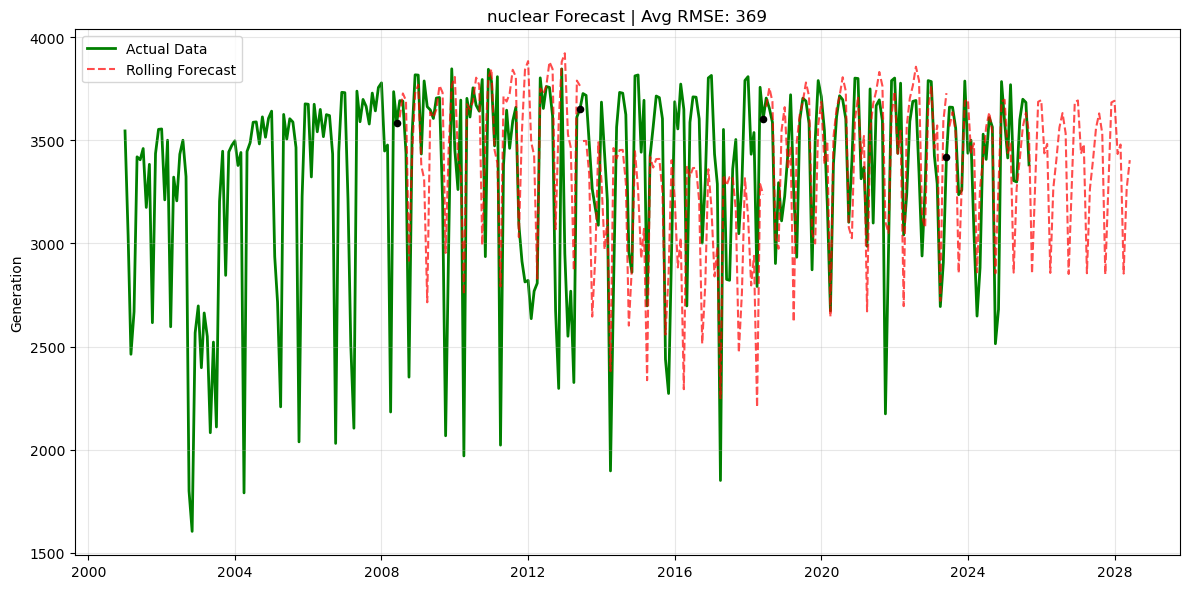

   > nuclear Average RMSE: 369.01


   > other gases Average RMSE: 70.56


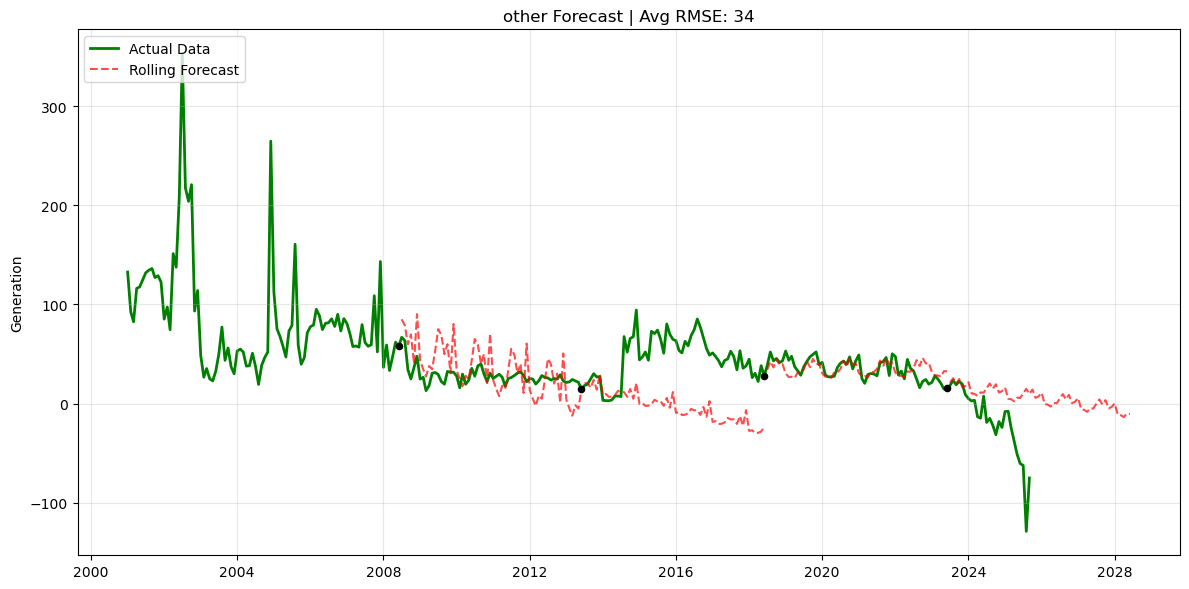

   > other Average RMSE: 33.56


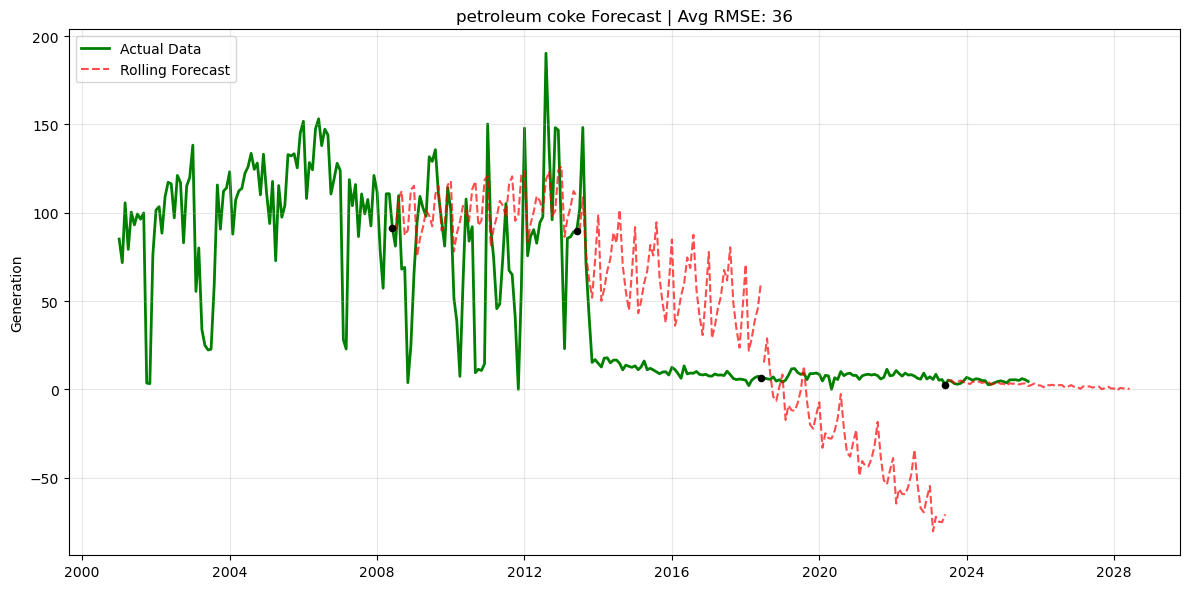

   > petroleum coke Average RMSE: 36.12


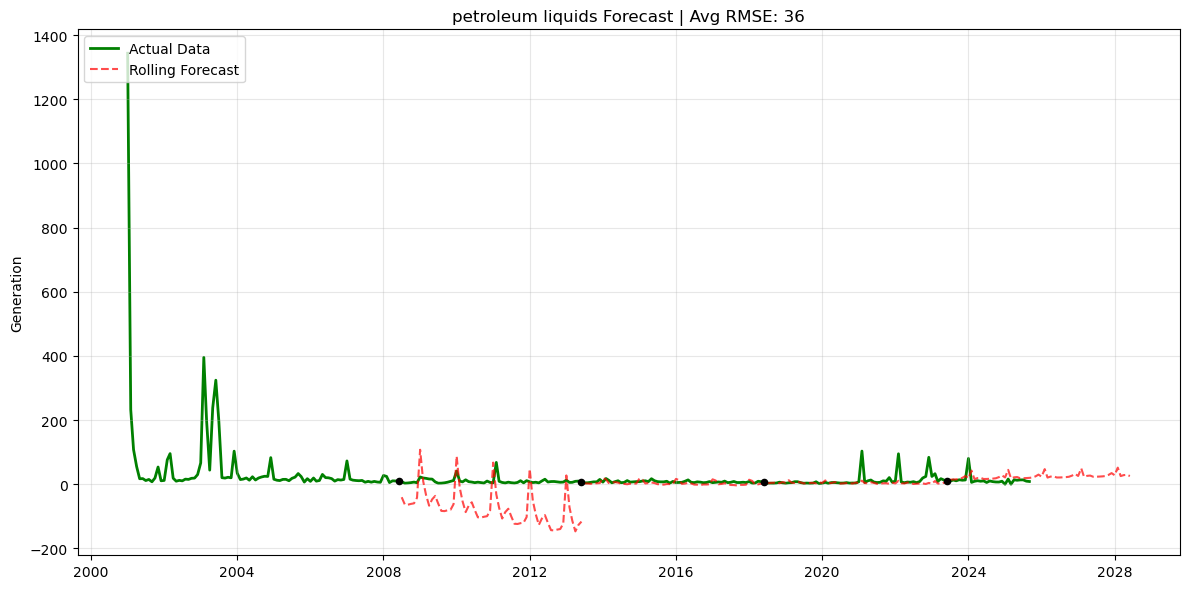

   > petroleum liquids Average RMSE: 35.79


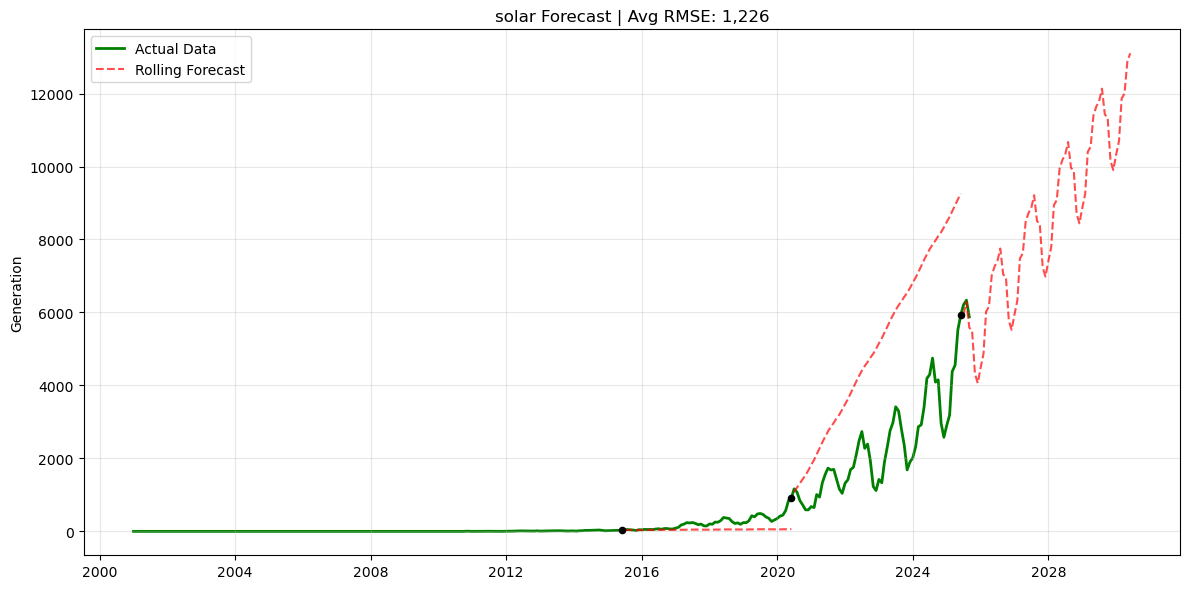

   > solar Average RMSE: 1,225.59


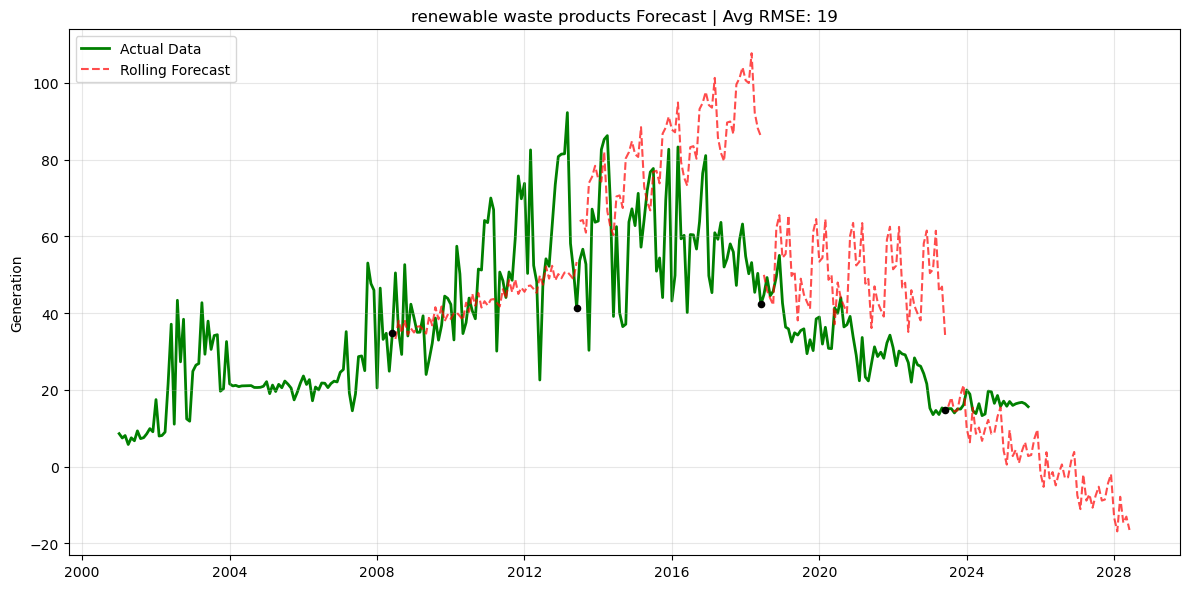

   > renewable waste products Average RMSE: 18.79


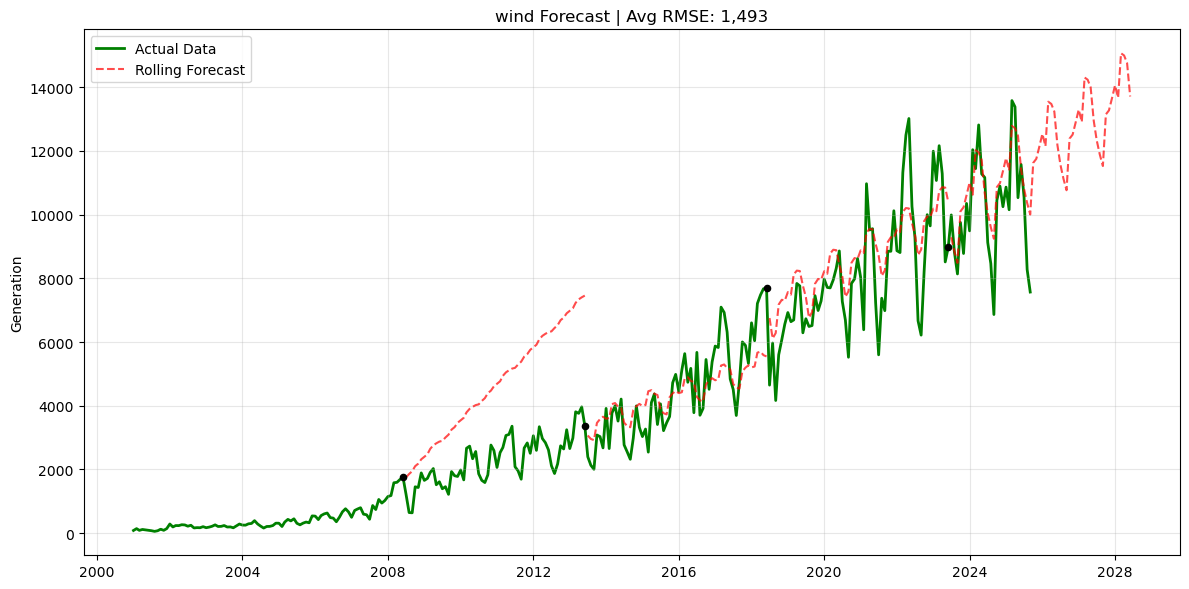

   > wind Average RMSE: 1,492.69


   > wood and wood wastes Average RMSE: 24.04


In [27]:

CHOSEN_MODEL = EWMA
TRAIN_WINDOW = 90
FORECAST_HORIZON = 60
STEP_SIZE = 60


all_errors_list = []


for i in SECTORS_MAP:
    
    series = fueltype_dfs[i]['generation'].dropna()
    
    results = run_backtest(
        series, 
        CHOSEN_MODEL, 
        TRAIN_WINDOW, 
        FORECAST_HORIZON, 
        STEP_SIZE
    )
    
    sector_errors_df = get_prediction_diffs(results, i)
    all_errors_list.append(sector_errors_df)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rmse = evaluate_and_plot(ax, i, results) 
    ax.set_ylabel("Generation")
    plt.title(f"{i} Forecast | Avg RMSE: {rmse:,.0f}")
    plt.tight_layout()
    plt.show()
    
    print(f"   > {i} Average RMSE: {rmse:,.2f}")





In [28]:
all_errors_df = pd.concat(all_errors_list, ignore_index=True)

print("\nSample of Prediction Differences:")
print(all_errors_df.head(10))


Sample of Prediction Differences:
      Sector Cutoff_Date Prediction_Date     Predicted       Actual  \
0  all fuels  2008-06-01      2008-07-01  41656.566387  42191.80399   
1  all fuels  2008-06-01      2008-08-01  42269.280819  41297.41181   
2  all fuels  2008-06-01      2008-09-01  36422.534314  32323.72551   
3  all fuels  2008-06-01      2008-10-01  32631.656685  30518.85383   
4  all fuels  2008-06-01      2008-11-01  30202.430424  27548.58167   
5  all fuels  2008-06-01      2008-12-01  32417.703121  30778.71705   
6  all fuels  2008-06-01      2009-01-01  33560.039732  30804.18013   
7  all fuels  2008-06-01      2009-02-01  30416.555951  26133.26562   
8  all fuels  2008-06-01      2009-03-01  30959.927958  29169.92578   
9  all fuels  2008-06-01      2009-04-01  30678.735855  28382.55439   

    Difference  
0  -535.237603  
1   971.869009  
2  4098.808804  
3  2112.802855  
4  2653.848754  
5  1638.986071  
6  2755.859602  
7  4283.290331  
8  1790.002178  
9  2296.18146

In [29]:
all_errors_df

Sector Cutoff_Date Prediction_Date     Predicted  \
0                all fuels  2008-06-01      2008-07-01  41656.566387   
1                all fuels  2008-06-01      2008-08-01  42269.280819   
2                all fuels  2008-06-01      2008-09-01  36422.534314   
3                all fuels  2008-06-01      2008-10-01  32631.656685   
4                all fuels  2008-06-01      2008-11-01  30202.430424   
...                    ...         ...             ...           ...   
2602  wood and wood wastes  2023-06-01      2025-05-01     99.987480   
2603  wood and wood wastes  2023-06-01      2025-06-01    107.217689   
2604  wood and wood wastes  2023-06-01      2025-07-01    113.255488   
2605  wood and wood wastes  2023-06-01      2025-08-01    129.470190   
2606  wood and wood wastes  2023-06-01      2025-09-01    100.165508   

           Actual   Difference  
0     42191.80399  -535.237603  
1     41297.41181   971.869009  
2     32323.72551  4098.808804  
3     30518.85383  2112.802855  
4     27548.58167  2653.848754  
...           ...          ...  
2602     43.55565    56.431830  
2603     58.19124    49.026449  
2604     66.67878    46.576708  
2605     84.92033    44.549860  
2606     79.22823    20.937278  

[2607 rows x 6 columns]

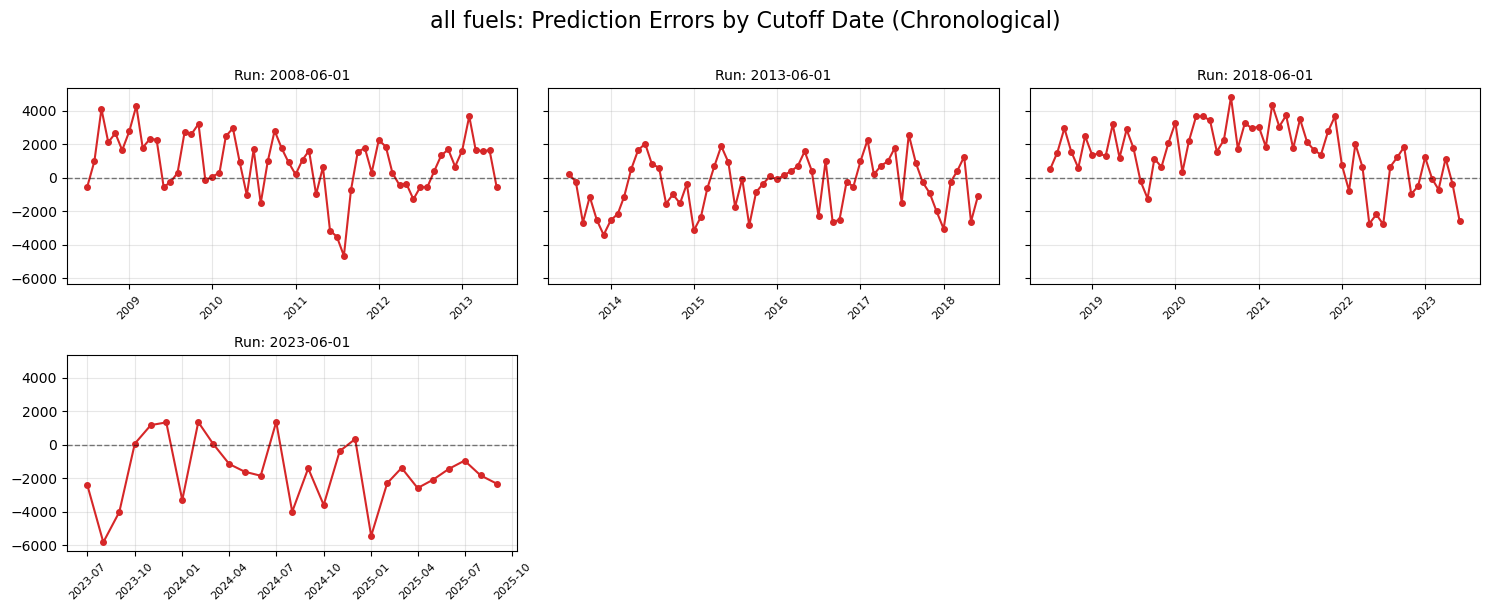

--------------------------------------------------------------------------------


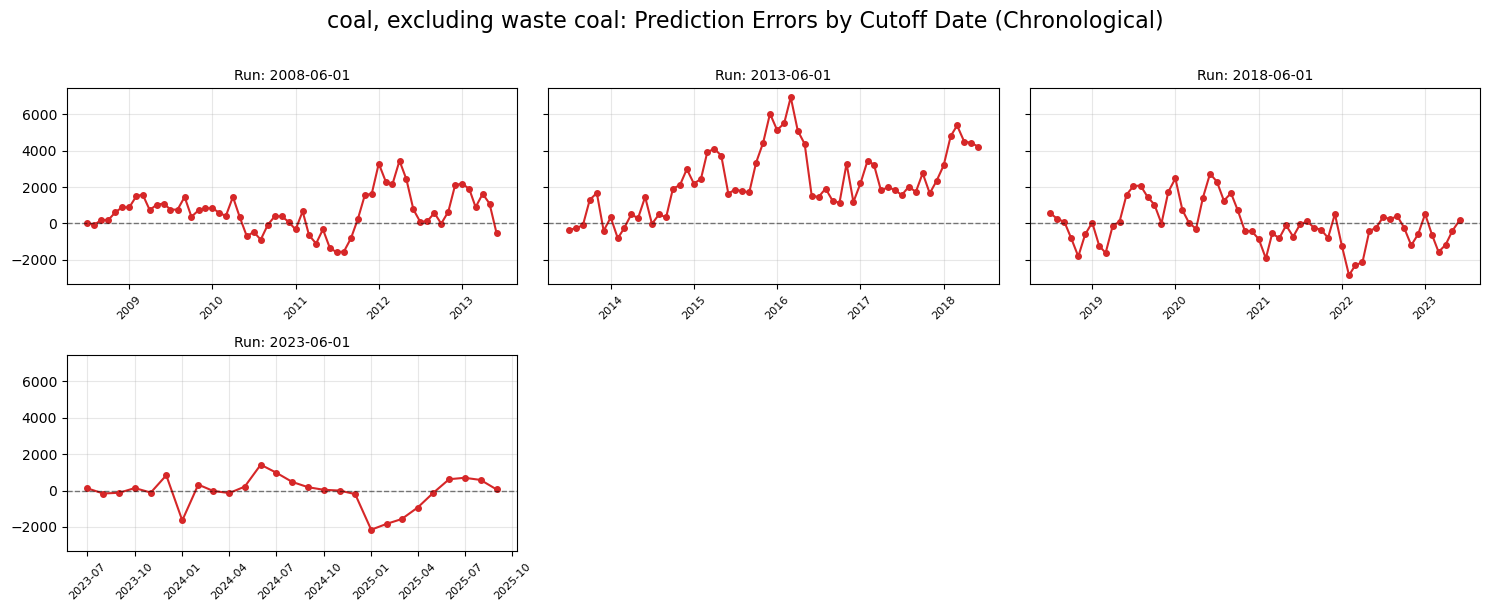

--------------------------------------------------------------------------------


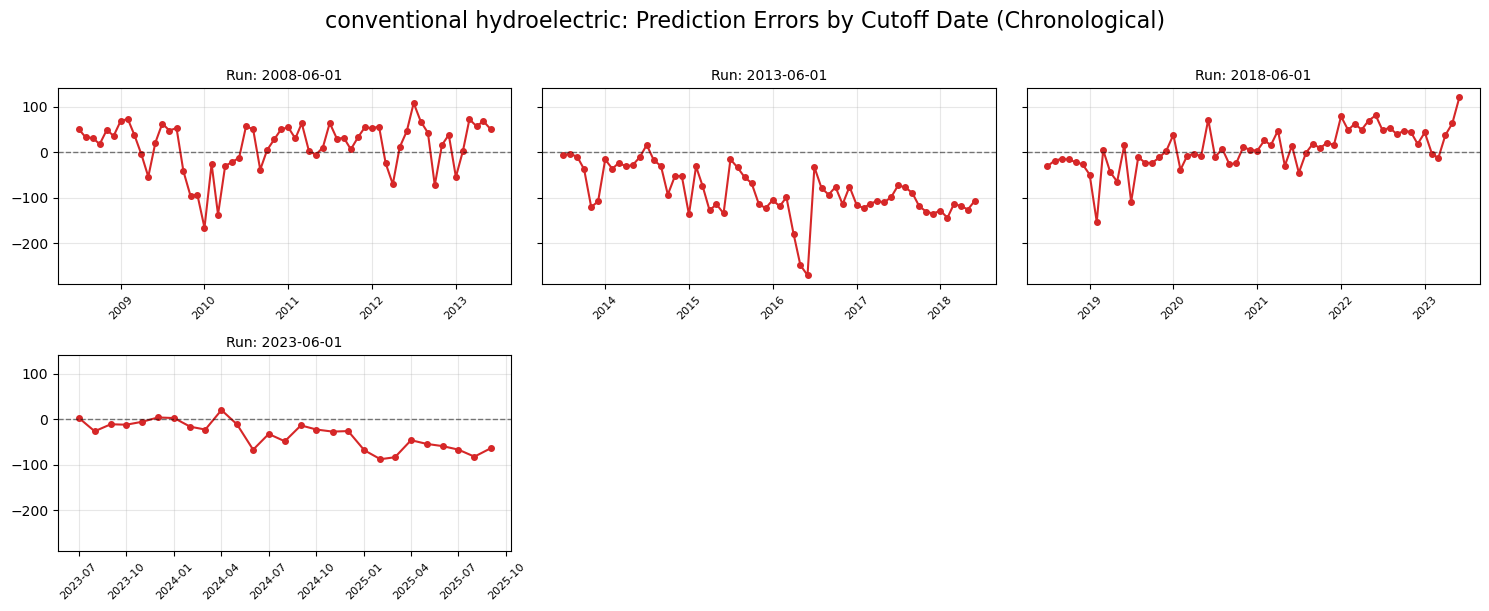

--------------------------------------------------------------------------------


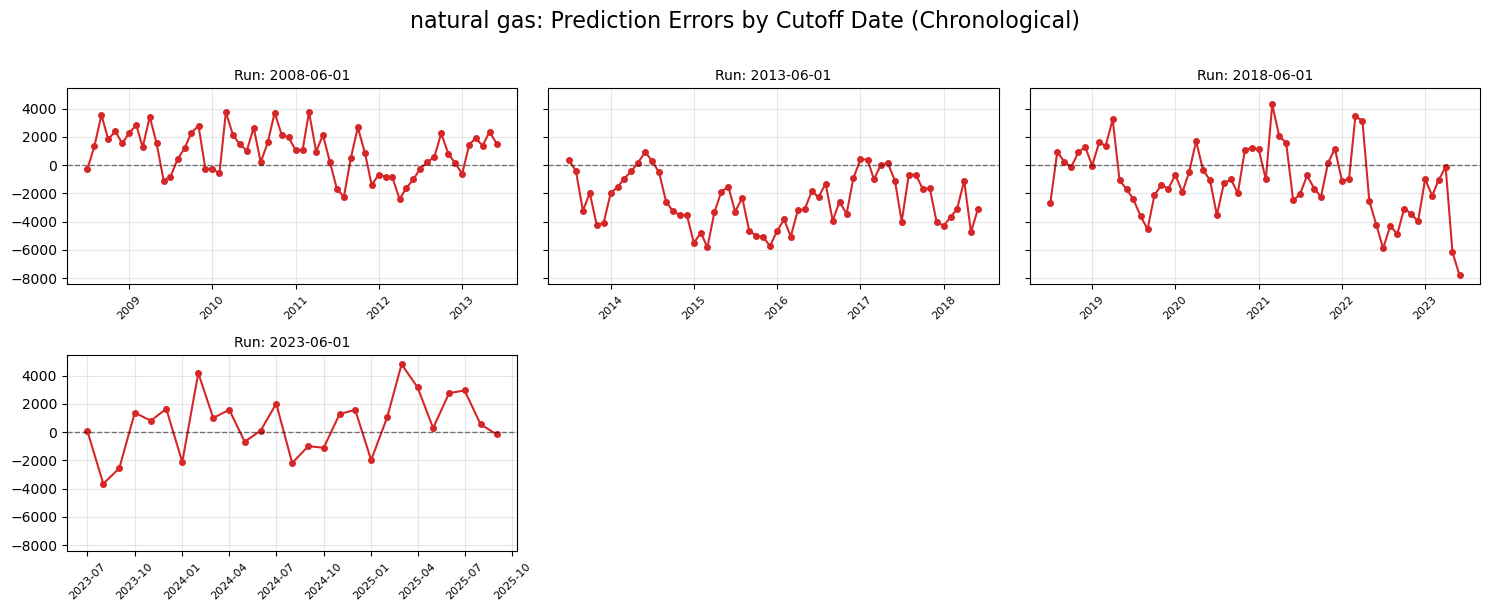

--------------------------------------------------------------------------------


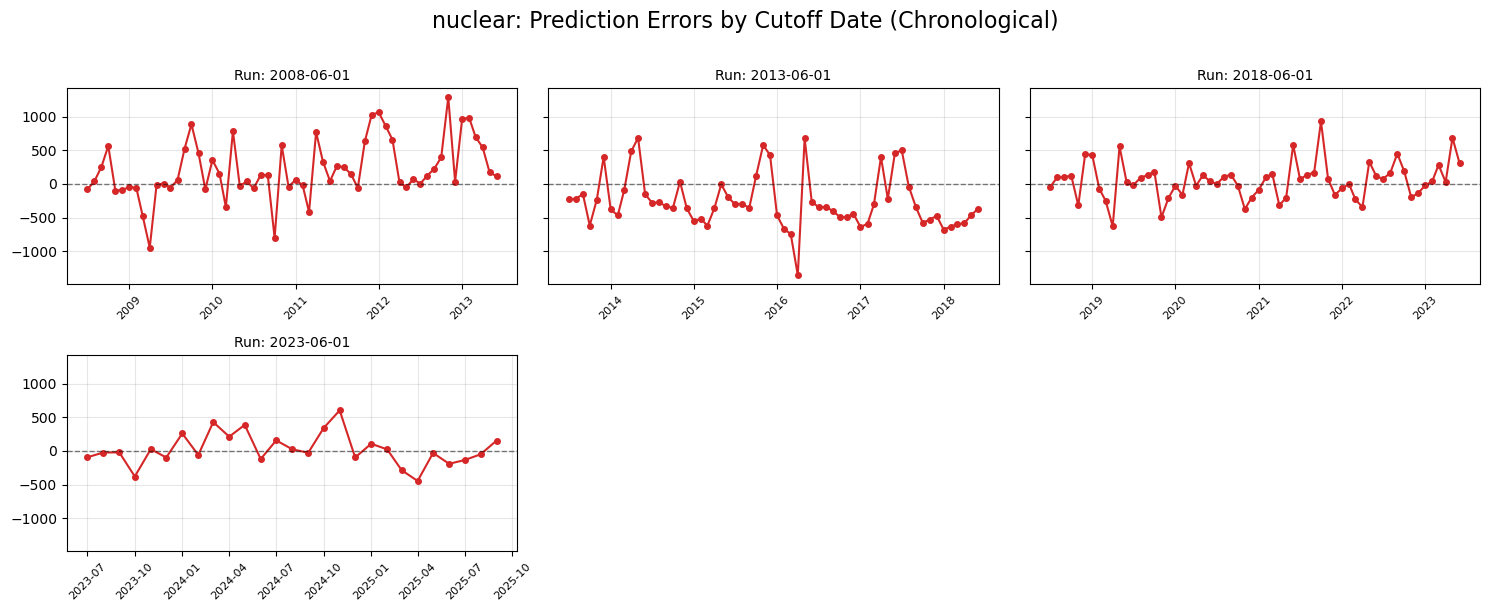

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


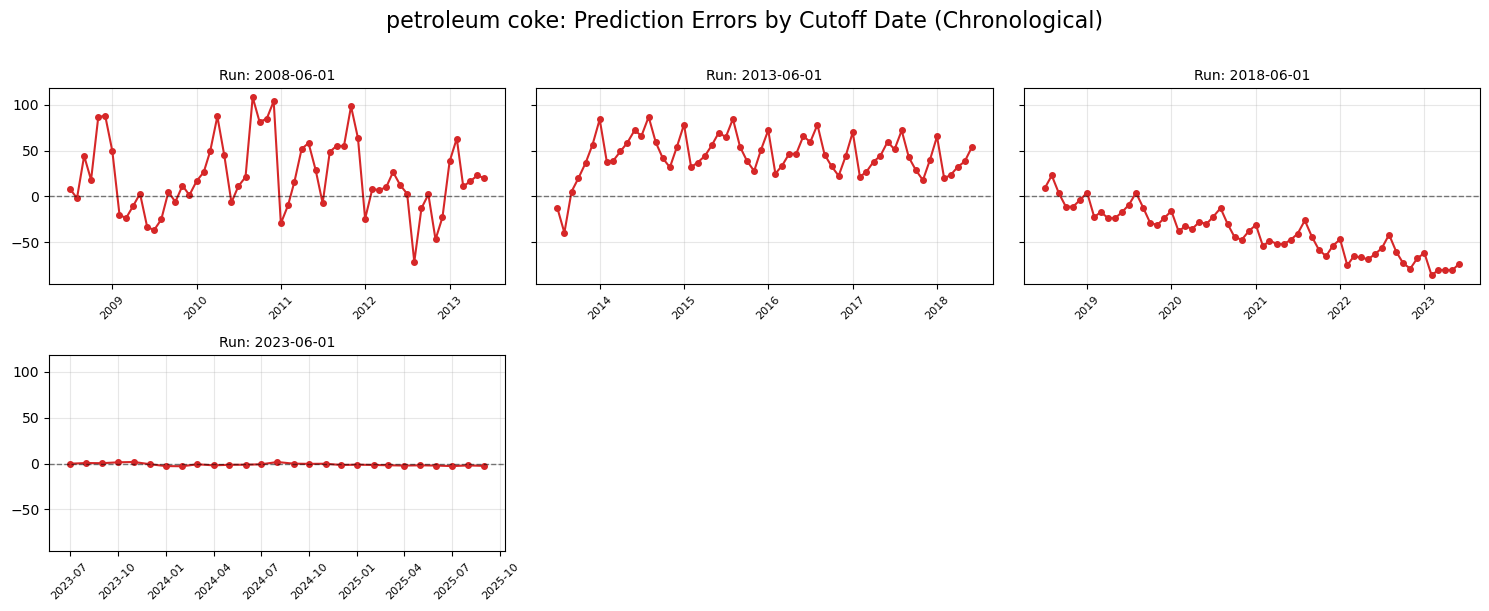

--------------------------------------------------------------------------------


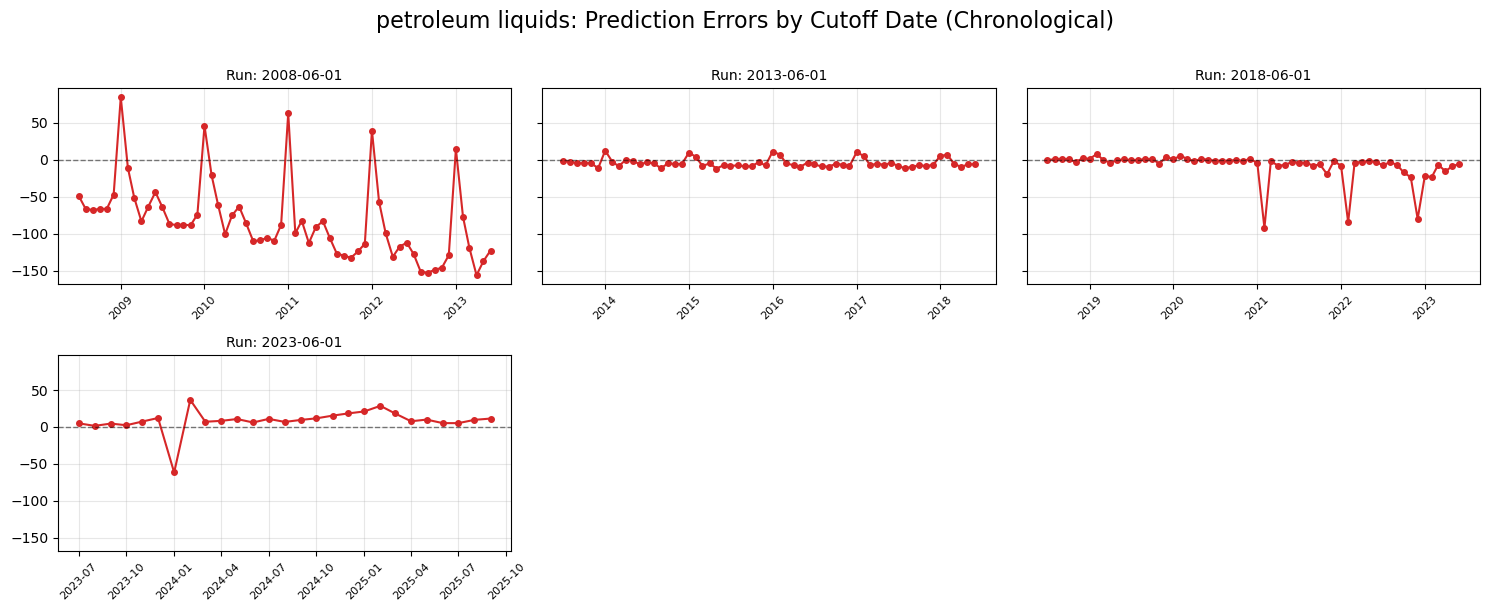

--------------------------------------------------------------------------------


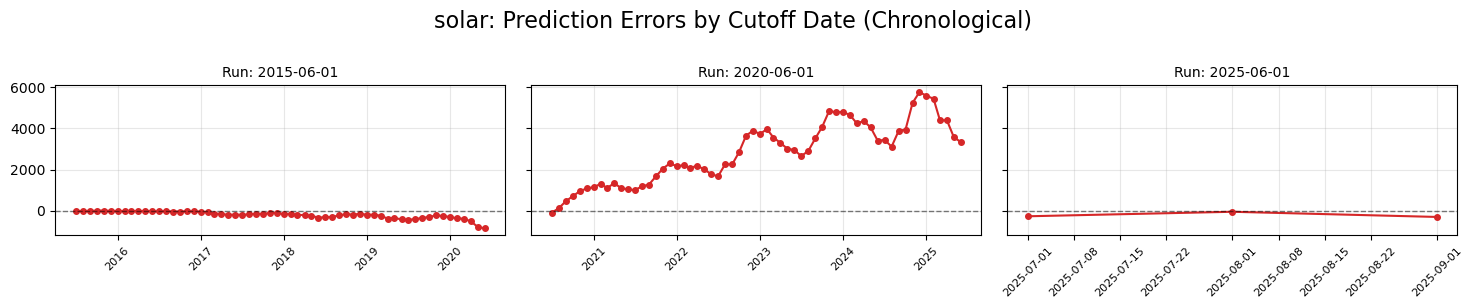

--------------------------------------------------------------------------------


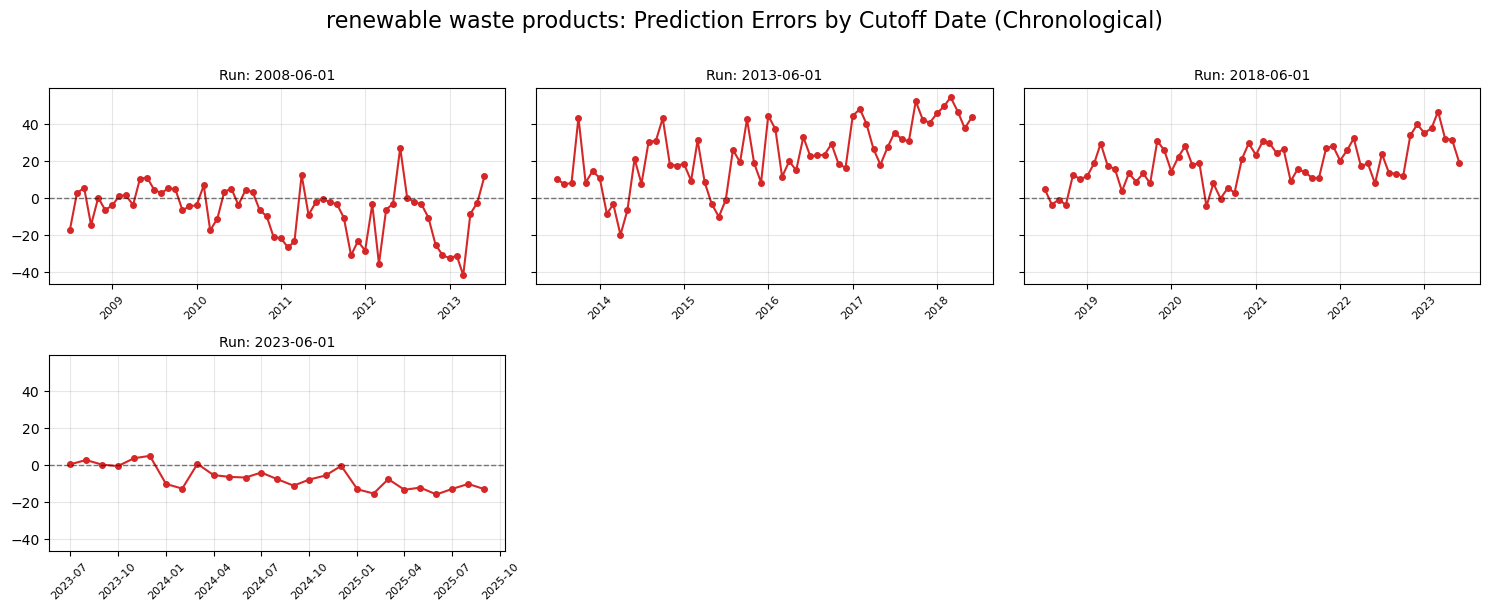

--------------------------------------------------------------------------------


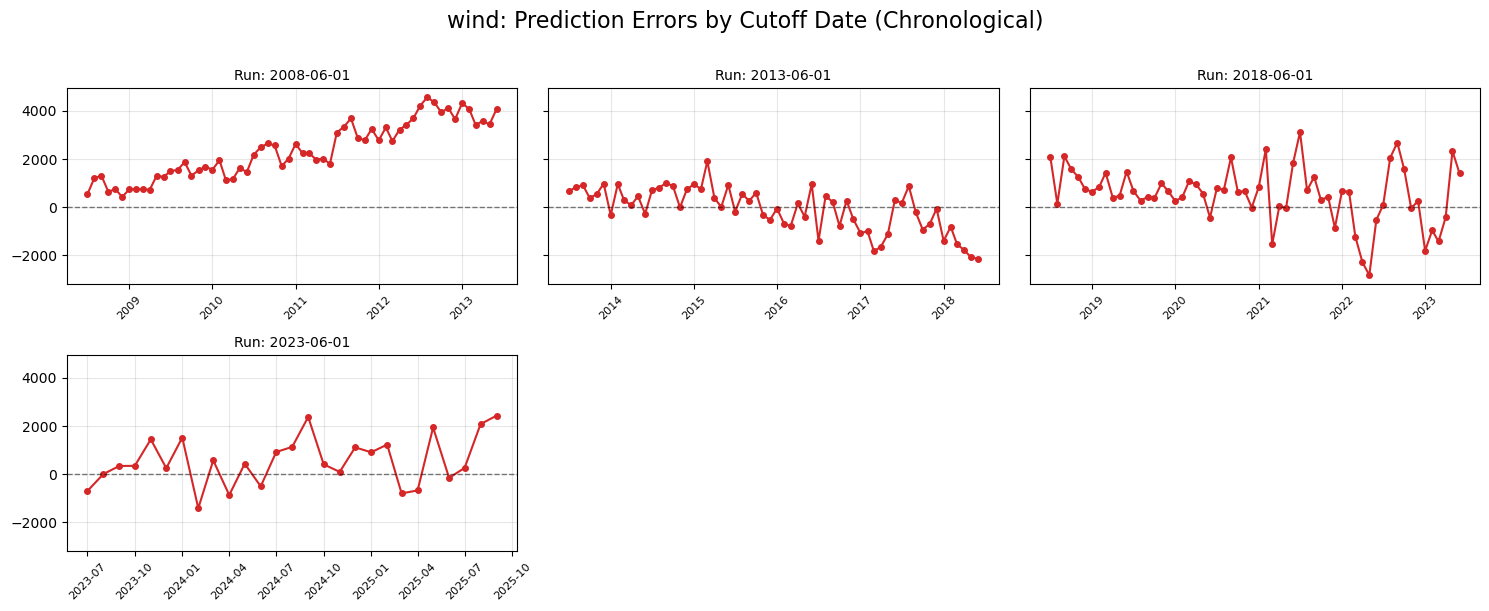

--------------------------------------------------------------------------------


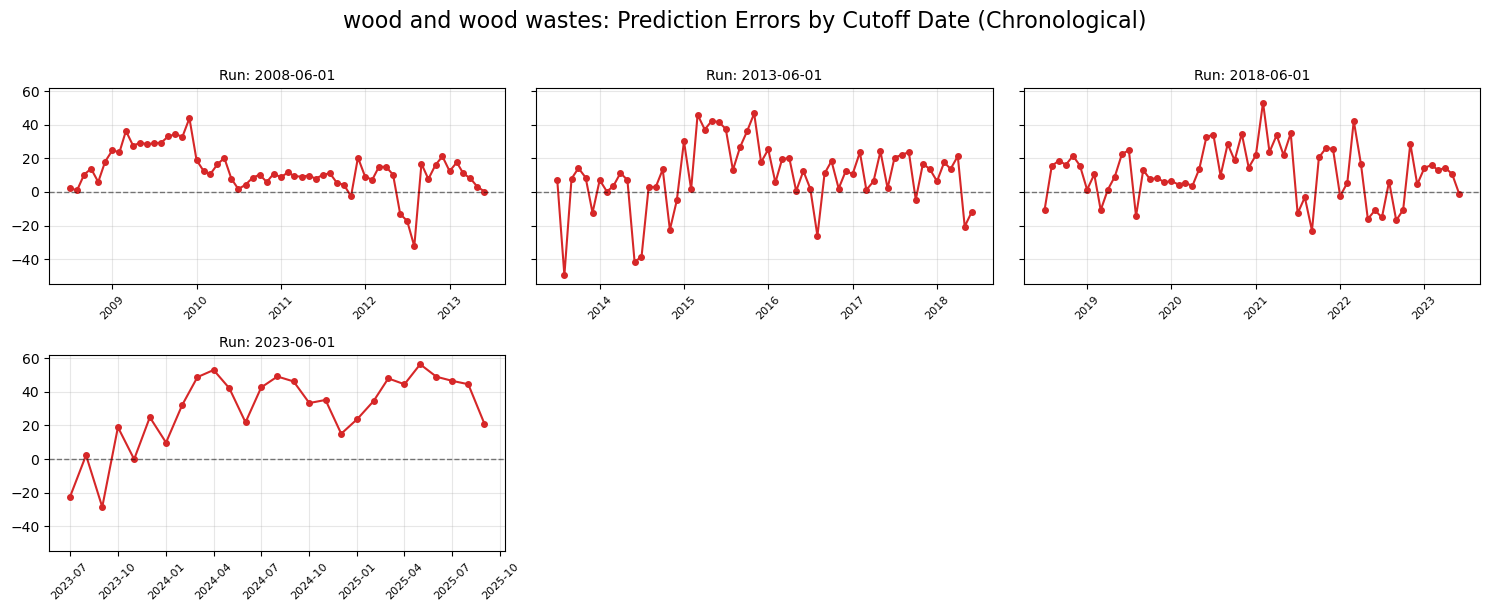

--------------------------------------------------------------------------------


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import math

sectors = all_errors_df['Sector'].unique()


for sector in sectors:
    sector_data = all_errors_df[all_errors_df['Sector'] == sector]
    cutoffs = sorted(sector_data['Cutoff_Date'].unique())
    
    num_plots = len(cutoffs)
    if num_plots == 0:
        continue

    # 1. Dynamic Grid Calculation
    cols = 3
    rows = math.ceil(num_plots / cols)
    
    # Create a large figure to hold the grid
    # Height increases with the number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows), sharey=True)
    axes = axes.flatten() # Flatten 2D array to 1D for easy looping
    
    fig.suptitle(f"{sector}: Prediction Errors by Cutoff Date (Chronological)", fontsize=16, y=1.01)

    # 2. Plot each Cutoff on its own axis
    for i, cutoff in enumerate(cutoffs):
        ax = axes[i]
        
        # Get data for JUST this specific forecast loop
        group = sector_data[sector_data['Cutoff_Date'] == cutoff]
        
        # Plot Error
        ax.plot(
            group['Prediction_Date'], 
            group['Difference'], 
            marker='o', 
            markersize=4,
            color='tab:red',
            linewidth=1.5
        )
        
        # Reference Line (Zero Error)
        ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Formatting individual subplots
        cutoff_str = pd.to_datetime(cutoff).strftime('%Y-%m-%d')
        ax.set_title(f"Run: {cutoff_str}", fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotated dates for readability
        ax.tick_params(axis='x', rotation=45, labelsize=8)

    # 3. Cleanup: Hide any empty subplots at the end
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print("-" * 80)

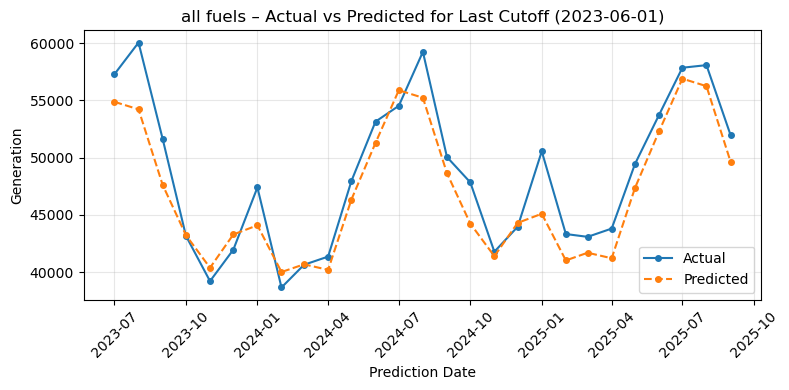

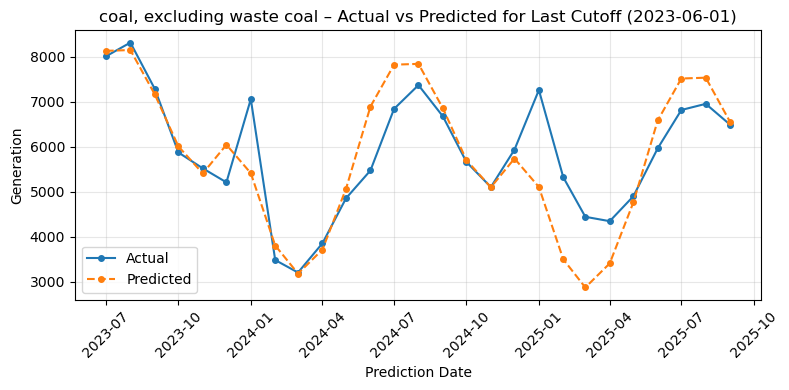

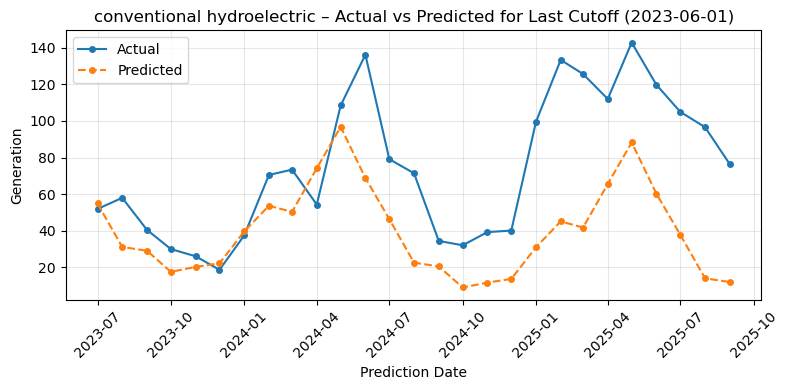

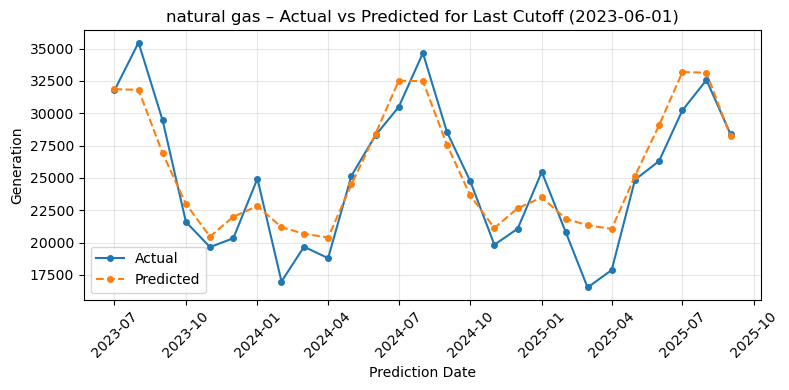

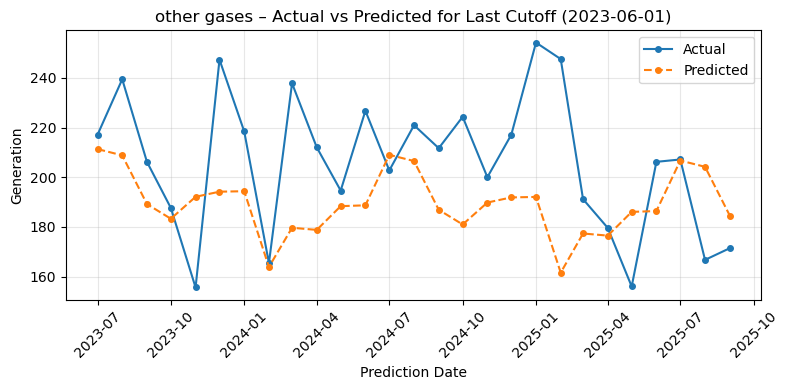

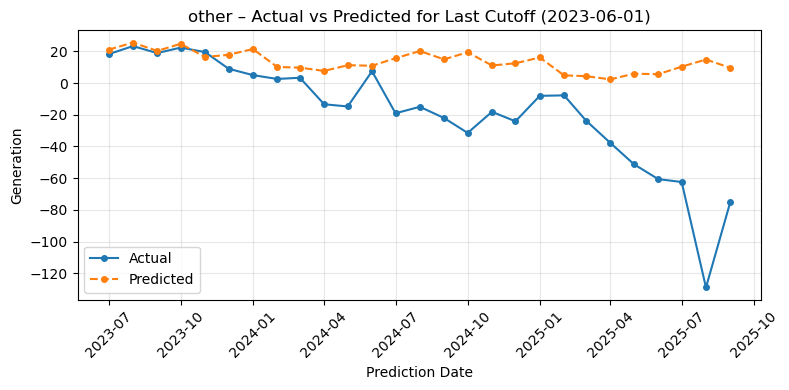

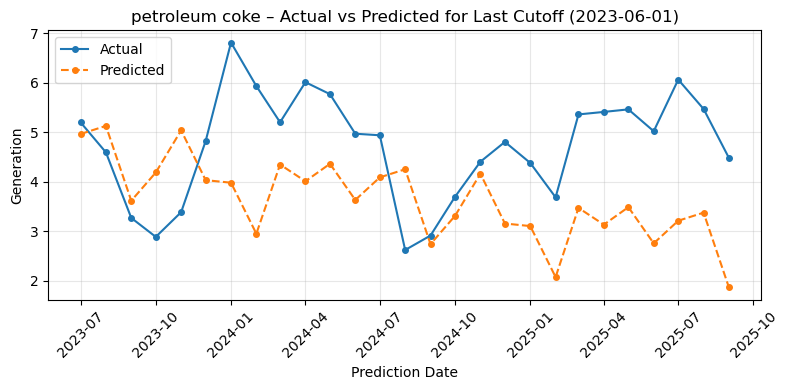

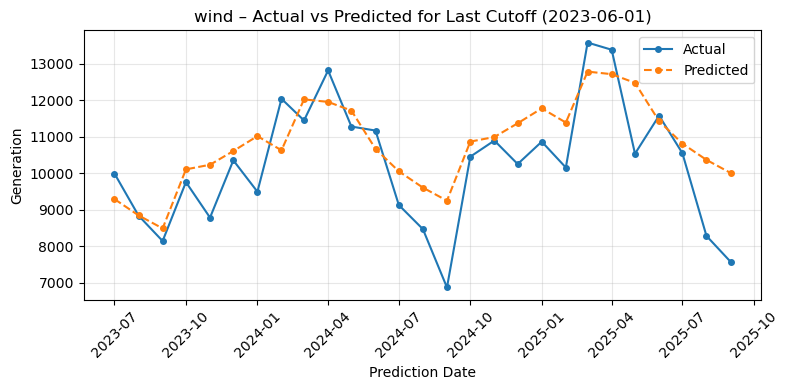

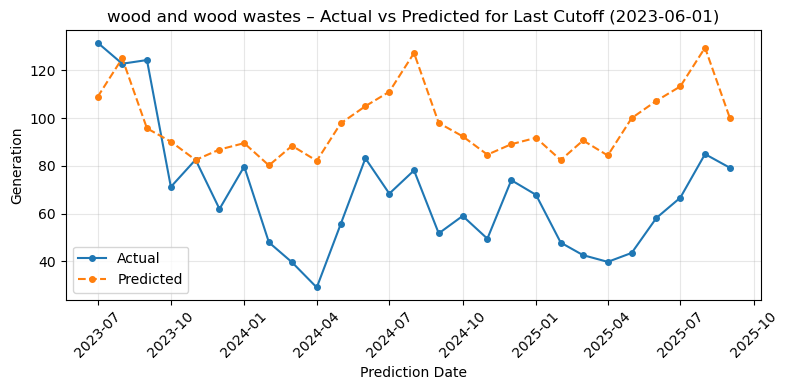

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

sectors = all_errors_df['Sector'].unique()

for sector in sectors:
    sector_data = all_errors_df[all_errors_df['Sector'] == sector]
    if sector_data.empty:
        continue

    last_cutoff = sector_data['Cutoff_Date'].max()

    group = sector_data[sector_data['Cutoff_Date'] == last_cutoff].copy()
    group = group.sort_values('Prediction_Date')

    plt.figure(figsize=(8, 4))

    # Plot TRUE values
    plt.plot(
        group['Prediction_Date'],
        group['Actual'],          # true generation
        marker='o',
        markersize=4,
        linewidth=1.5,
        label='Actual'
    )

    # Plot PREDICTED values
    plt.plot(
        group['Prediction_Date'],
        group['Predicted'],       # model forecast
        marker='o',
        markersize=4,
        linewidth=1.5,
        linestyle='--',
        label='Predicted'
    )

    cutoff_str = pd.to_datetime(last_cutoff).strftime('%Y-%m-%d')
    plt.title(f"{sector} – Actual vs Predicted for Last Cutoff ({cutoff_str})")
    plt.ylabel("Generation")
    plt.xlabel("Prediction Date")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

def analyze_last_cutoff_residuals(all_errors_df,
                                  sectors_to_plot=None,
                                  eps=1e-9,
                                  max_lag_acf=15):

    df = all_errors_df.copy()

    # Ensure dates are proper datetimes
    df['Cutoff_Date'] = pd.to_datetime(df['Cutoff_Date'])
    df['Prediction_Date'] = pd.to_datetime(df['Prediction_Date'])

    # Residual = Predicted - Actual
    if 'Difference' in df.columns:
        # assume Difference already = Predicted - Actual
        df['Residual'] = df['Difference']
    else:
        df['Residual'] = df['Predicted'] - df['Actual']



    last_cutoff_per_sector = df.groupby('Sector')['Cutoff_Date'].transform('max')
    df_last = df[df['Cutoff_Date'] == last_cutoff_per_sector].copy()

    # At this point df_last is the working dataset:
    #   one or more rows per sector, all from that sector's last cutoff date.
    if df_last.empty:
        print("No data after filtering to last cutoff per sector.")
        return None




    def _sector_metrics(g):
        resid = g['Residual']
        abs_err = resid.abs()
        sq_err = resid.pow(2)

        mask = g['Actual'].abs() > eps

        mae = abs_err.mean()
        rmse = np.sqrt(sq_err.mean())
        bias = resid.mean()
        mape = (abs_err[mask] / g.loc[mask, 'Actual'].abs()).mean() * 100

        return pd.Series({
            "MAE": mae,
            "RMSE": rmse,
            "Bias": bias,
            "MAPE_%": mape
        })

    per_sector_metrics = (
        df_last.groupby('Sector', sort=True)
               .apply(_sector_metrics)
               .sort_index()
    )

    print("Per-sector metrics (last cutoff only):")
    print(per_sector_metrics)




    resid_all = df_last['Residual']
    abs_err_all = resid_all.abs()
    sq_err_all = resid_all.pow(2)
    mask_all = df_last['Actual'].abs() > eps

    global_mae = abs_err_all.mean()
    global_rmse = np.sqrt(sq_err_all.mean())
    global_mape = (abs_err_all[mask_all] /
                   df_last.loc[mask_all, 'Actual'].abs()).mean() * 100

    print("\nGlobal metrics (last cutoff, all sectors stacked):")
    print(f"MAE    : {global_mae:.4f}")
    print(f"RMSE   : {global_rmse:.4f}")
    print(f"MAPE % : {global_mape:.2f}")




    all_sectors = df_last['Sector'].unique()
    if sectors_to_plot is None:
        sectors_to_plot = list(all_sectors)
    else:
        # keep only those present
        sectors_to_plot = [s for s in sectors_to_plot if s in all_sectors]

    if not sectors_to_plot:
        print("\nNo sectors to plot (requested sectors not found in last-cutoff data).")
        return per_sector_metrics



    fig, axes = plt.subplots(len(sectors_to_plot), 1,
                             figsize=(8, 3 * len(sectors_to_plot)))
    if len(sectors_to_plot) == 1:
        axes = [axes]

    for ax, sector in zip(axes, sectors_to_plot):
        g = df_last[df_last['Sector'] == sector]
        ax.hist(g['Residual'].dropna(), bins=30, alpha=0.7)
        ax.set_title(f"Residual histogram – {sector} (last cutoff)")
        ax.set_xlabel("Residual (Pred - Actual)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    fig, axes = plt.subplots(len(sectors_to_plot), 1,
                             figsize=(6, 4 * len(sectors_to_plot)))
    if len(sectors_to_plot) == 1:
        axes = [axes]

    for ax, sector in zip(axes, sectors_to_plot):
        g = df_last[df_last['Sector'] == sector]
        ax.scatter(g['Actual'], g['Predicted'], alpha=0.4, s=12)
        min_val = min(g['Actual'].min(), g['Predicted'].min())
        max_val = max(g['Actual'].max(), g['Predicted'].max())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
        ax.set_title(f"Predicted vs Actual – {sector} (last cutoff)")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

  
    ref_sector = sectors_to_plot[0]
    ref = df_last[df_last['Sector'] == ref_sector].sort_values('Prediction_Date')
    ref_resid = ref.set_index('Prediction_Date')['Residual'].dropna()

    plt.figure(figsize=(8, 4))
    plot_acf(ref_resid, lags=15)
    plt.title(f"ACF of residuals – {ref_sector} (last cutoff)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 5))
    qqplot(ref_resid, line="s")
    plt.title(f"QQ plot of residuals – {ref_sector} (last cutoff)")
    plt.tight_layout()
    plt.show()

    return per_sector_metrics

In [33]:
all_errors_df

Sector Cutoff_Date Prediction_Date     Predicted  \
0                all fuels  2008-06-01      2008-07-01  41656.566387   
1                all fuels  2008-06-01      2008-08-01  42269.280819   
2                all fuels  2008-06-01      2008-09-01  36422.534314   
3                all fuels  2008-06-01      2008-10-01  32631.656685   
4                all fuels  2008-06-01      2008-11-01  30202.430424   
...                    ...         ...             ...           ...   
2602  wood and wood wastes  2023-06-01      2025-05-01     99.987480   
2603  wood and wood wastes  2023-06-01      2025-06-01    107.217689   
2604  wood and wood wastes  2023-06-01      2025-07-01    113.255488   
2605  wood and wood wastes  2023-06-01      2025-08-01    129.470190   
2606  wood and wood wastes  2023-06-01      2025-09-01    100.165508   

           Actual   Difference  
0     42191.80399  -535.237603  
1     41297.41181   971.869009  
2     32323.72551  4098.808804  
3     30518.85383  2112.802855  
4     27548.58167  2653.848754  
...           ...          ...  
2602     43.55565    56.431830  
2603     58.19124    49.026449  
2604     66.67878    46.576708  
2605     84.92033    44.549860  
2606     79.22823    20.937278  

[2607 rows x 6 columns]

Per-sector metrics (last cutoff only):
                                    MAE         RMSE         Bias      MAPE_%
Sector                                                                       
all fuels                   2061.013430  2526.111087 -1643.260624    4.110814
coal, excluding waste coal   581.527981   848.618873   -87.156222   10.135247
conventional hydroelectric    36.742197    45.656078   -34.629381   46.079202
natural gas                 1732.676762  2121.918346   593.660949    7.636528
nuclear                      177.205375   237.252054    24.929606    5.642746
other                         31.660732    44.782004    31.430619  135.525078
other gases                   25.874441    33.208060   -16.734166   12.134419
petroleum coke                 1.484516     1.707474    -1.079449   31.172211
petroleum liquids             13.066820    17.904020     8.503390  117.505458
renewable waste products       7.499579     8.917898    -6.499611   45.175117
solar                    

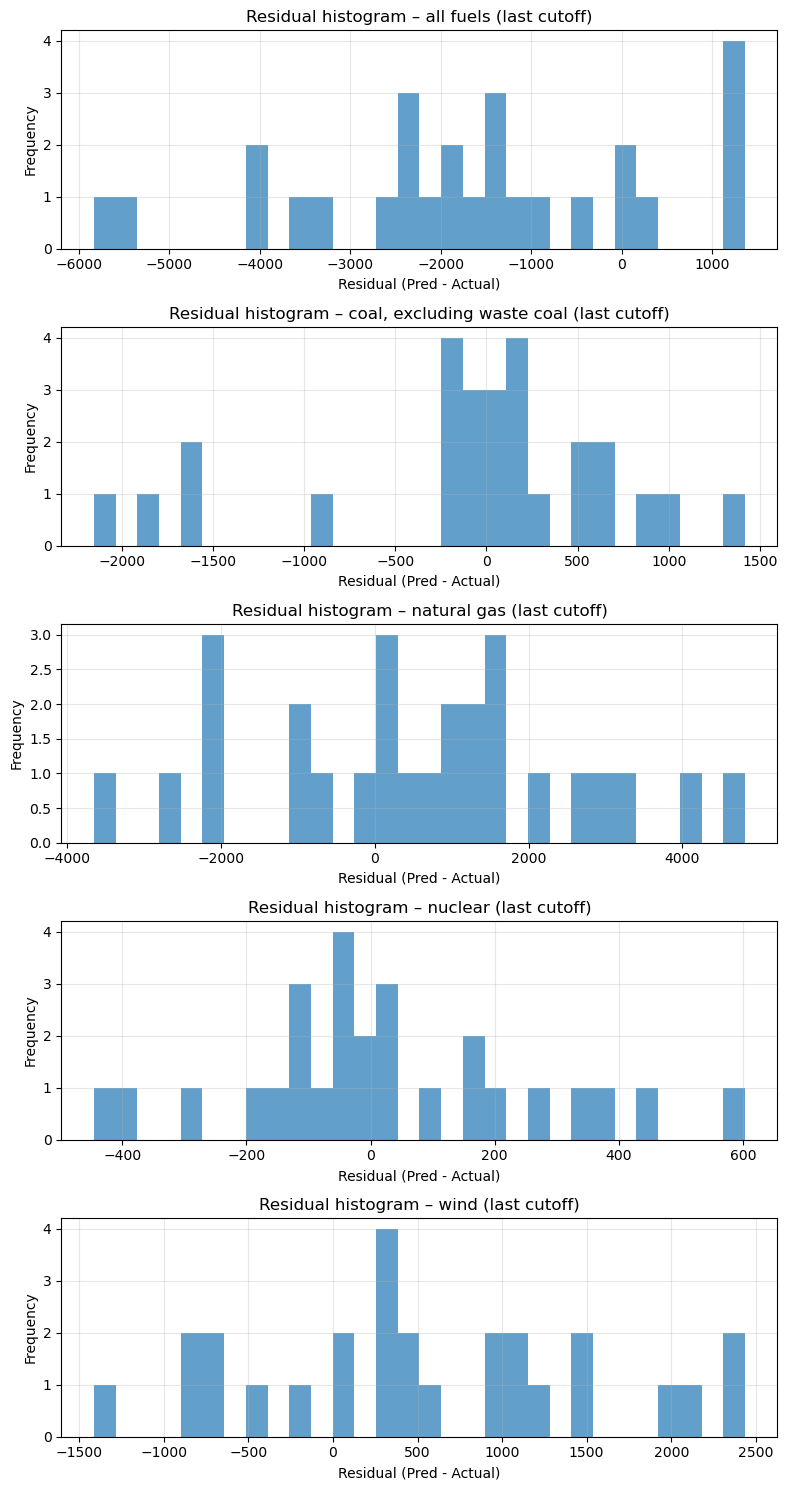

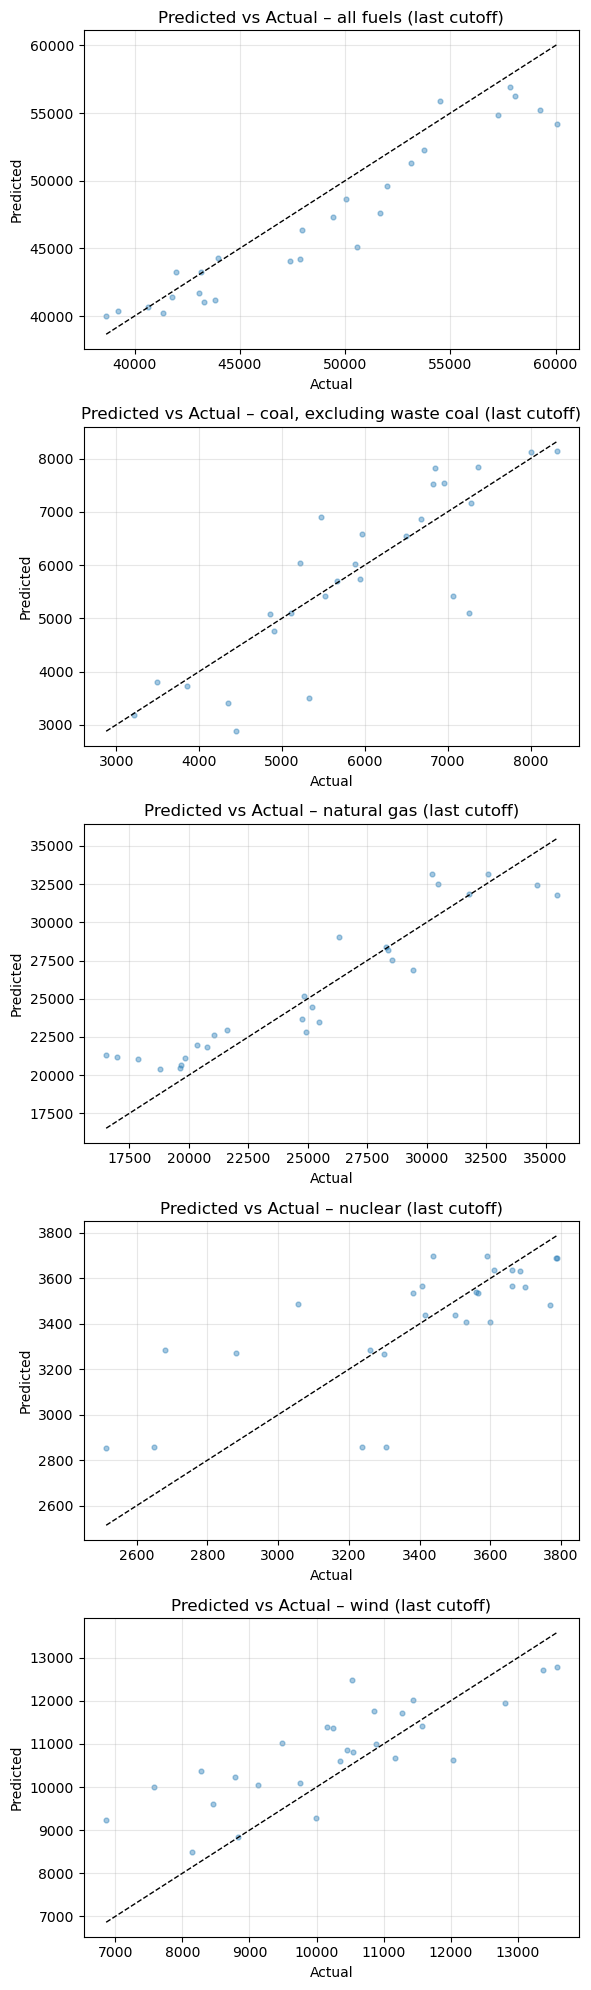

<Figure size 800x400 with 0 Axes>

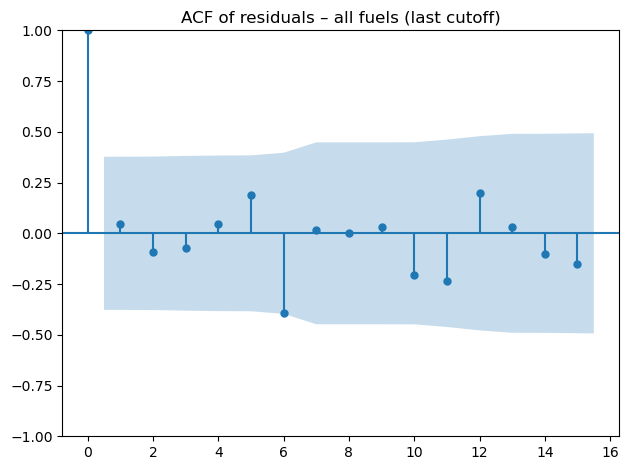

<Figure size 500x500 with 0 Axes>

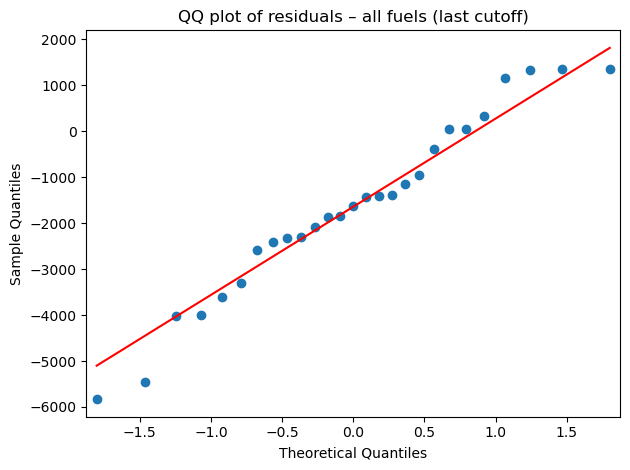

In [34]:
sectors_to_plot = ['all fuels', 'coal, excluding waste coal', 'natural gas', 'nuclear', 'wind'] 

per_sector_metrics =  analyze_last_cutoff_residuals(all_errors_df, sectors_to_plot=sectors_to_plot, eps=1e-9, max_lag_acf=32)

In [35]:
#Addtive model does better on coal and natural gas. 

In [36]:
per_sector_metrics

MAE         RMSE         Bias      MAPE_%
Sector                                                                       
all fuels                   2061.013430  2526.111087 -1643.260624    4.110814
coal, excluding waste coal   581.527981   848.618873   -87.156222   10.135247
conventional hydroelectric    36.742197    45.656078   -34.629381   46.079202
natural gas                 1732.676762  2121.918346   593.660949    7.636528
nuclear                      177.205375   237.252054    24.929606    5.642746
other                         31.660732    44.782004    31.430619  135.525078
other gases                   25.874441    33.208060   -16.734166   12.134419
petroleum coke                 1.484516     1.707474    -1.079449   31.172211
petroleum liquids             13.066820    17.904020     8.503390  117.505458
renewable waste products       7.499579     8.917898    -6.499611   45.175117
solar                        202.269013   230.873790  -202.269013    3.341988
wind                         925.391490  1147.804234   548.052946    9.884861
wood and wood wastes          33.167590    36.555486    29.351363   61.226000

Per-sector metrics (last cutoff only):
                                    MAE         RMSE         Bias      MAPE_%
Sector                                                                       
all fuels                   2061.013430  2526.111087 -1643.260624    4.110814
coal, excluding waste coal   581.527981   848.618873   -87.156222   10.135247
conventional hydroelectric    36.742197    45.656078   -34.629381   46.079202
natural gas                 1732.676762  2121.918346   593.660949    7.636528
nuclear                      177.205375   237.252054    24.929606    5.642746
other                         31.660732    44.782004    31.430619  135.525078
other gases                   25.874441    33.208060   -16.734166   12.134419
petroleum coke                 1.484516     1.707474    -1.079449   31.172211
petroleum liquids             13.066820    17.904020     8.503390  117.505458
renewable waste products       7.499579     8.917898    -6.499611   45.175117
solar                    

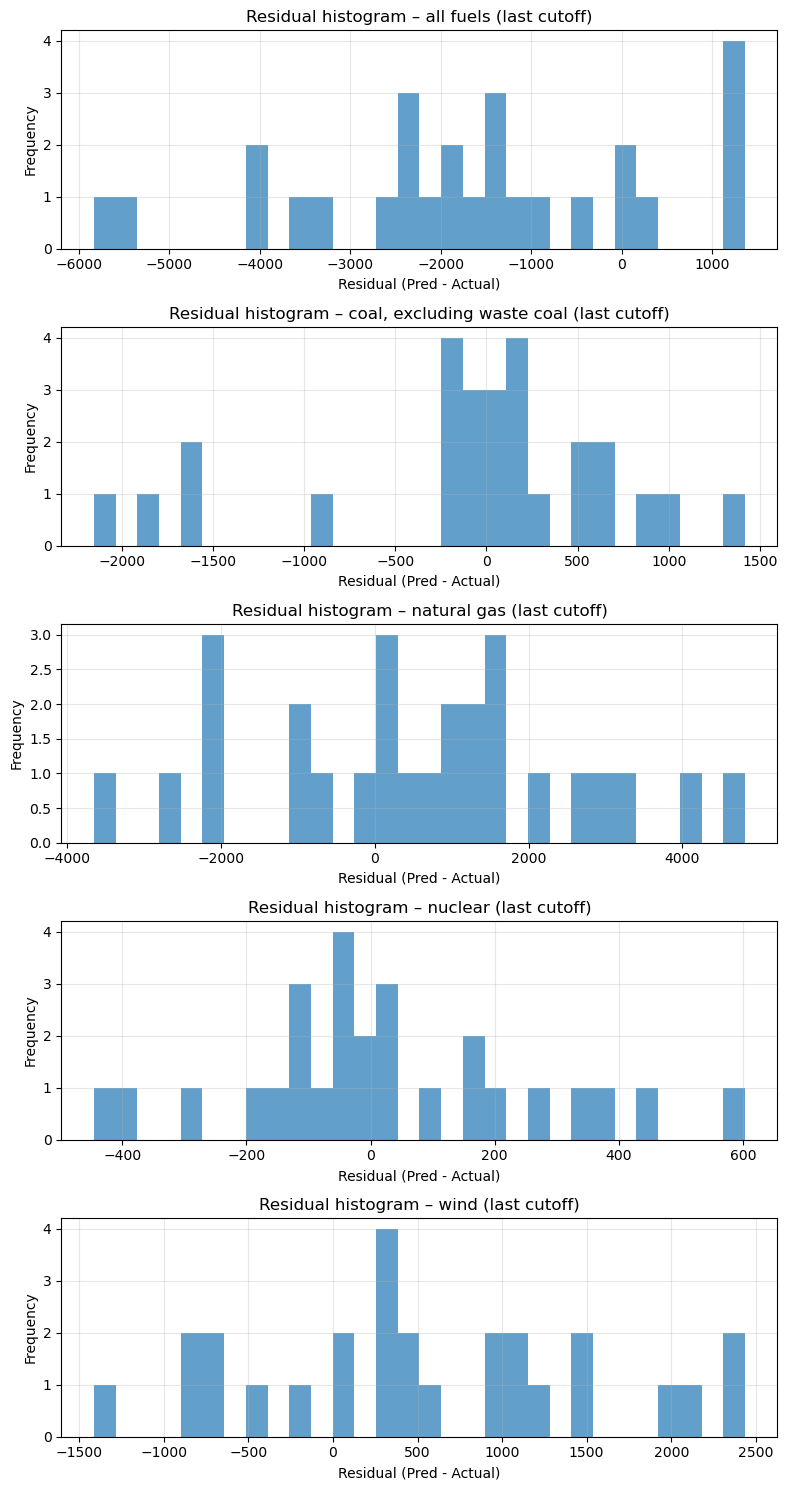

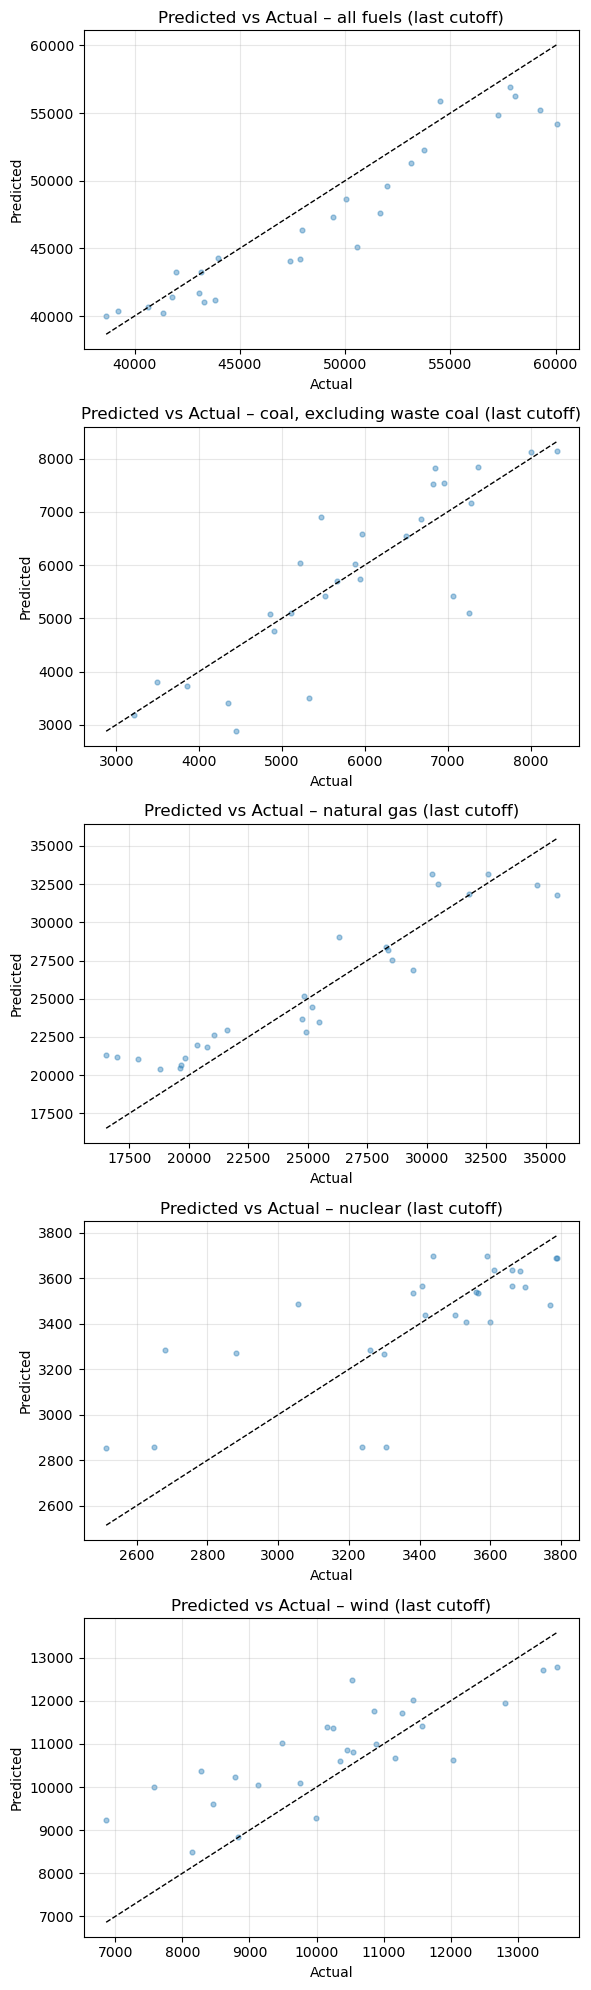

<Figure size 800x400 with 0 Axes>

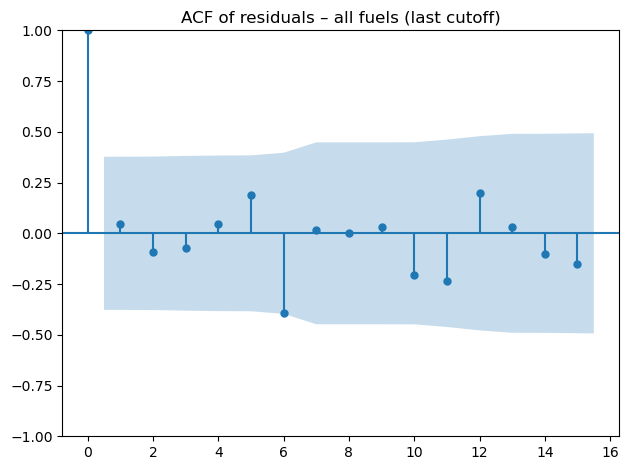

<Figure size 500x500 with 0 Axes>

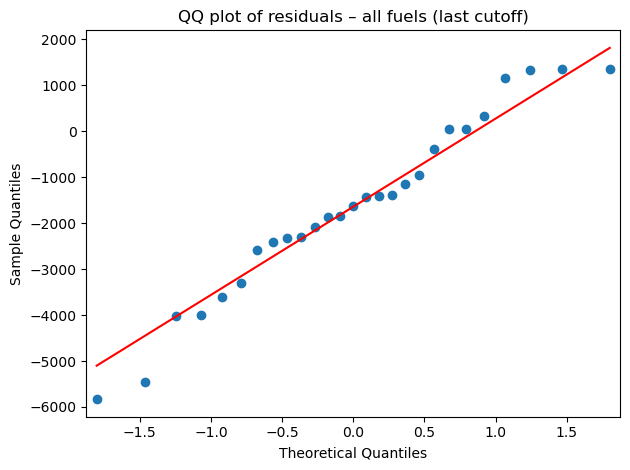

In [37]:
per_sector_metrics_sarima =  analyze_last_cutoff_residuals(all_errors_df, sectors_to_plot=sectors_to_plot, eps=1e-9, max_lag_acf=32)